In [1]:
# Import necessary libraries
import tensorflow as tf
import numpy as np
import pandas as pd
import joblib
import os
from tensorflow.keras.layers import Dense, Input, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, Nadam
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

# Suppress TensorFlow warnings and set random seeds
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
np.random.seed(42)
tf.random.set_seed(42)

2025-04-03 11:30:36.636871: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743679836.688540    2184 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743679836.702682    2184 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1743679836.811842    2184 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1743679836.811999    2184 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1743679836.812003    2184 computation_placer.cc:177] computation placer alr

In [2]:
# Load training dataset
train = pd.read_csv("../DATA/train.csv")

# Handle missing values
train = train.dropna()

/tmp/ipykernel_2184/514651788.py:2: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16) have mixed types. Specify dtype option on import or set low_memory=False.
  train = pd.read_csv("../DATA/train.csv")


In [3]:
# Convert Protocol column safely
train['Protocol'] = pd.to_numeric(train['Protocol'], errors='coerce') 
train = train.dropna(subset=['Protocol']) 
train['Protocol'] = train['Protocol'].astype(int)

In [4]:
# Prepare columns for feature selection
columns = list(train.columns) 
columns = [col for col in columns if col not in ['Fwd PSH Flags', 'RST Flag Cnt', 'PSH Flag Cnt', 'ACK Flag Cnt', 'Protocol', 'Label']]

# Separate features and target
x = train.drop(columns=['Label'])
y = train['Label']

In [5]:
# Convert all columns to numeric safely
x[columns] = x[columns].apply(pd.to_numeric, errors='coerce')
flag_cols = ['Fwd PSH Flags', 'RST Flag Cnt', 'PSH Flag Cnt', 'ACK Flag Cnt']
x[flag_cols] = x[flag_cols].apply(pd.to_numeric, errors='coerce')
x = x.fillna(0)

In [6]:
# Load and apply scaler
sc = joblib.load('../FEATURE_EXTRACTION/scaler.pkl')  
x[columns] = sc.transform(x[columns])

In [7]:
# Encode labels
le = LabelEncoder()
ye = le.fit_transform(y)

In [8]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(x, ye, test_size=0.15, random_state=42, stratify=ye)

In [9]:
# Compute class weights for imbalanced data
class_counts = np.bincount(y_train)
total_samples = np.sum(class_counts)
class_weights = {i: total_samples / (len(class_counts) * count) for i, count in enumerate(class_counts)}

In [10]:
# Load DBN weights from RBM pre-trained layers
dbn_weights = [
    np.load("../FEATURE_EXTRACTION/rbm_layer_1_weights.npz"),
    np.load("../FEATURE_EXTRACTION/rbm_layer_2_weights.npz"),
    np.load("../FEATURE_EXTRACTION/rbm_layer_3_weights.npz")
]

In [11]:
# Build MLP model with proper weight initialization
input_dim = X_train.shape[1]
num_classes = len(np.unique(y))
inputs = Input(shape=(input_dim,))

# Check DBN weights compatibility
dbn_w1 = dbn_weights[0]['W']
dbn_b1 = dbn_weights[0]['bh']

print(f"DBN Layer 1 weights shape: {dbn_w1.shape}")  # Should be (17, 128)
print(f"Model first layer expects: (17, 512)")

# Initialize first layer properly
if dbn_w1.shape == (input_dim, 128):
    # Use DBN weights for first 128 units, random init for remaining 384
    initial_weights = np.random.normal(size=(input_dim, 512))
    initial_weights[:, :128] = dbn_w1  # Insert DBN weights
    
    initial_biases = np.zeros(512)
    initial_biases[:128] = dbn_b1
    
    x = Dense(512, activation='swish',
              kernel_initializer=tf.constant_initializer(initial_weights),
              bias_initializer=tf.constant_initializer(initial_biases),
              kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4))(inputs)
else:
    # Fallback to random initialization
    print("DBN weights incompatible - using random initialization")
    x = Dense(512, activation='swish',
              kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4))(inputs)

x = BatchNormalization()(x)
x = Dropout(0.5)(x)

# Continue with remaining layers
x = Dense(256, activation='swish', kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4))(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)

x = Dense(128, activation='swish', kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4))(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = Dense(64, activation='swish', kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4))(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)

# Output layer
outputs = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)
model.summary()

DBN Layer 1 weights shape: (17, 128)
Model first layer expects: (17, 512)


I0000 00:00:1743679909.618501    2184 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 43629 MB memory:  -> device: 0, name: NVIDIA L40S, pci bus id: 0000:34:00.0, compute capability: 8.9


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 17)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │         9,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 15)             │           975 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 186,511 (728.56 KB)

 Trainable params: 184,591 (721.06 KB)

 Non-trainable params: 1,920 (7.50 KB)

In [12]:
# Define training callbacks
callbacks = [
    EarlyStopping(monitor='val_accuracy', patience=25, restore_best_weights=True, mode='max', verbose=1),
    ReduceLROnPlateau(monitor='val_accuracy', factor=0.2, patience=10, min_lr=1e-7, mode='max', verbose=1),
    ModelCheckpoint('best_mlp_model.keras', monitor='val_accuracy', save_best_only=True, mode='max'),
    TensorBoard(log_dir='./logs', histogram_freq=1)
]

# Training Phases
# Phase 1: Train only top layers
for layer in model.layers[:-6]:
    layer.trainable = False
print("\nPhase 1: Warmup Training (Top Layers Only)")
model.compile(optimizer=Adam(learning_rate=1e-3),
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

history1 = model.fit(X_train, y_train, validation_data=(X_test, y_test),
                     epochs=50, batch_size=2048, class_weight=class_weights,
                     callbacks=callbacks, verbose=1)


Phase 1: Warmup Training (Top Layers Only)


Epoch 1/50


I0000 00:00:1743679917.014417    4298 service.cc:152] XLA service 0x7fdabc008200 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1743679917.014617    4298 service.cc:160]   StreamExecutor device (0): NVIDIA L40S, Compute Capability 8.9
2025-04-03 11:31:57.074730: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1743679917.306532    4298 cuda_dnn.cc:529] Loaded cuDNN version 90300


   1/5053 ━━━━━━━━━━━━━━━━━━━━ 5:42:25 4s/step - accuracy: 0.0913 - loss: 3.8357

I0000 00:00:1743679919.490342    4298 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


5053/5053 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step - accuracy: 0.0436 - loss: 2.7219 - val_accuracy: 6.7681e-04 - val_loss: 2.9634 - learning_rate: 0.0010
Epoch 2/50
5053/5053 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.0288 - loss: 2.5429 - val_accuracy: 2.7379e-05 - val_loss: 2.8025 - learning_rate: 0.0010
Epoch 3/50
5053/5053 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.0120 - loss: 2.5275 - val_accuracy: 2.7379e-05 - val_loss: 2.8094 - learning_rate: 0.0010
Epoch 4/50
5053/5053 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.0150 - loss: 2.5275 - val_accuracy: 7.1186e-06 - val_loss: 2.7222 - learning_rate: 0.0010
Epoch 5/50
5053/5053 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.0114 - loss: 2.5289 - val_accuracy: 7.1186e-06 - val_loss: 2.7664 - learning_rate: 0.0010
Epoch 6/50
5053/5053 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.0127 - loss: 2.5114 - val_accuracy: 6.7791e-04 - val_loss: 2.7395 - learning_rate: 0.0010
Epoch 7/50
5053/5053 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - 

In [ ]:
for layer in model.layers[:-10]:
    layer.trainable = False

model.compile(optimizer=Adam(learning_rate=5e-4),
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

print("\nPhase 2: Intermediate Training (Middle Layers)")
history2 = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=60,
    batch_size=1024,
    class_weight=class_weights,
    callbacks=callbacks,
    verbose=1
)


Phase 2: Intermediate Training (Middle Layers)
Epoch 1/60
10106/10106 ━━━━━━━━━━━━━━━━━━━━ 31s 3ms/step - accuracy: 0.0213 - loss: 2.5019 - val_accuracy: 2.7379e-05 - val_loss: 2.6038 - learning_rate: 5.0000e-04
Epoch 2/60
10106/10106 ━━━━━━━━━━━━━━━━━━━━ 24s 2ms/step - accuracy: 0.0116 - loss: 2.4915 - val_accuracy: 2.7379e-05 - val_loss: 2.5575 - learning_rate: 5.0000e-04
Epoch 3/60
10106/10106 ━━━━━━━━━━━━━━━━━━━━ 24s 2ms/step - accuracy: 0.0152 - loss: 2.4954 - val_accuracy: 2.7927e-05 - val_loss: 2.6188 - learning_rate: 5.0000e-04
Epoch 4/60
10106/10106 ━━━━━━━━━━━━━━━━━━━━ 24s 2ms/step - accuracy: 0.0179 - loss: 2.4894 - val_accuracy: 2.7927e-05 - val_loss: 2.5863 - learning_rate: 5.0000e-04
Epoch 5/60
10106/10106 ━━━━━━━━━━━━━━━━━━━━ 24s 2ms/step - accuracy: 0.0096 - loss: 2.4924 - val_accuracy: 2.7927e-05 - val_loss: 2.6333 - learning_rate: 5.0000e-04
Epoch 6/60
10088/10106 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0051 - loss: 2.4972

In [ ]:
# Phase 3: Full Training (all layers)
for layer in model.layers:
    layer.trainable = True

model.compile(optimizer=Nadam(learning_rate=1e-4),
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

print("\nPhase 3: Full Network Training")
history3 = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=80,
    batch_size=512,
    class_weight=class_weights,
    callbacks=callbacks,
    verbose=1
)

In [ ]:
# Phase 4: Fine-tuning (very low LR)
model.compile(optimizer=Nadam(learning_rate=1e-5),
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

print("\nPhase 4: Fine-Tuning")
history4 = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=100,
    batch_size=256,
    class_weight=class_weights,
    callbacks=callbacks,
    verbose=1
)

In [13]:
# Evaluate the trained model
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Display classification report
print("\n=== Classification Report ===")
print(classification_report(y_test, y_pred_classes, target_names=le.classes_))

57069/57069 ━━━━━━━━━━━━━━━━━━━━ 49s 858us/step

=== Classification Report ===


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                          precision    recall  f1-score   support

                  Benign       0.78      0.69      0.73   1517030
                     Bot       0.00      0.00      0.00     32196
        Brute Force -Web       0.00      0.00      0.00        69
        Brute Force -XSS       0.00      0.00      0.00        26
        DDOS attack-HOIC       0.00      0.00      0.00     77176
    DDOS attack-LOIC-UDP       0.00      0.00      0.00       195
  DDoS attacks-LOIC-HTTP       0.00      0.00      0.00     64821
   DoS attacks-GoldenEye       0.00      0.00      0.00      4670
        DoS attacks-Hulk       0.00      0.00      0.00     51965
DoS attacks-SlowHTTPTest       0.00      0.00      0.00     15738
   DoS attacks-Slowloris       0.00      0.00      0.00      1236
          FTP-BruteForce       0.00      0.00      0.00     21753
           Infilteration       0.00      0.00      0.00     18218
           SQL Injection       0.00      0.00      0.00        10
         

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


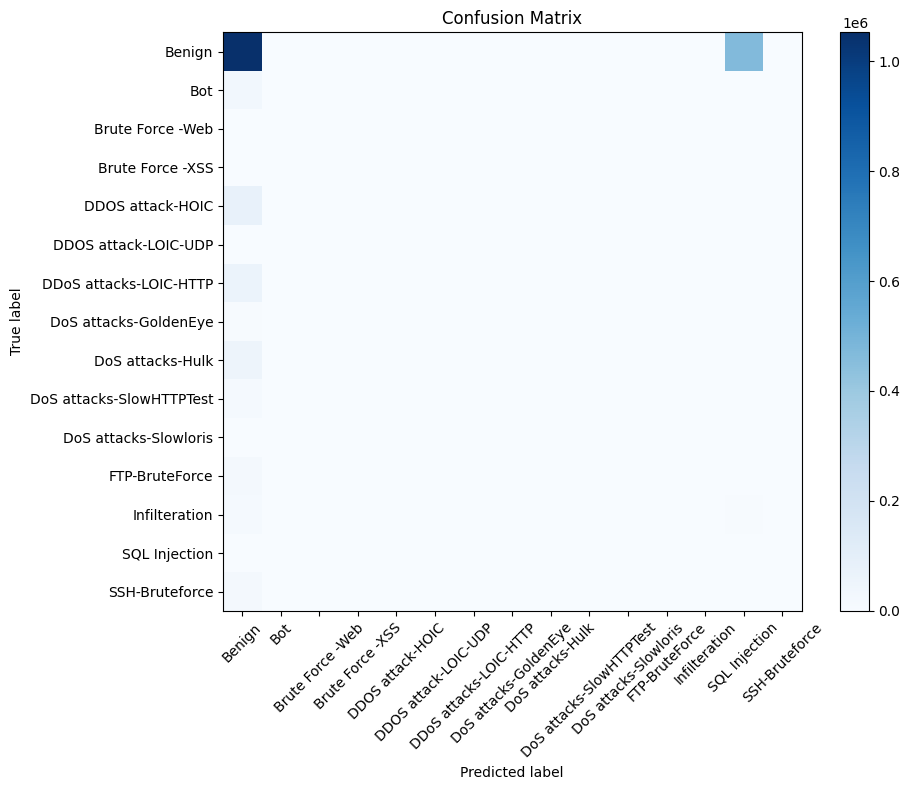

In [14]:
# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(10, 8))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(le.classes_))
plt.xticks(tick_marks, le.classes_, rotation=45)
plt.yticks(tick_marks, le.classes_)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

In [15]:
# Save the trained model
model.save("high_accuracy_mlp_model.keras")
print("\n=== Training Complete ===")
print("Saved model: high_accuracy_mlp_model.keras")


=== Training Complete ===
Saved model: high_accuracy_mlp_model.keras
